In [1]:
from pathlib import Path
from fastai.vision.all import *

Train the model using resnet

In [2]:
dls = ImageDataLoaders.from_folder(
    Path('../data/processed'), 
    train='train', 
    valid_pct=0.2,
    size=224,
    bs=4,
    shuffle_train=True,
    # item_tfms=Resize(256, method=ResizeMethod.Squish)
)

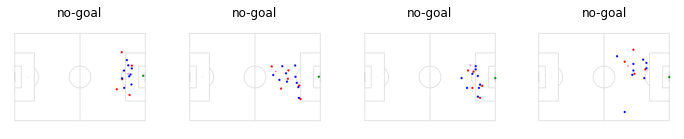

In [3]:
dls.show_batch(nrows=1, ncols=4)

In [4]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.528438,0.699041,0.108081,0.891919,04:39


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.462672,0.390094,0.098990,0.901010,05:57


Review the model

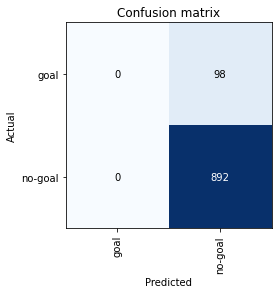

In [5]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Make some predictions on the test-data.

First, let's go through predicting a single image...

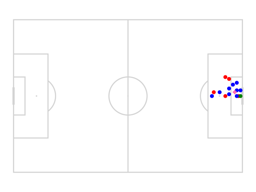

In [6]:
import PIL

# Load an image from the test data
example_img = PILImage.create('../data/processed/test/goal/07d8857c-00fc-4f4d-b1ae-86b1ed377133.png')

display(example_img.to_thumb(256, 256))

In [7]:
_, _, probs = learn.predict(example_img)

xg, _ = probs

print(f'xG: {float(xg)}')

xG: 0.09645641595125198


Load all test data

In [8]:
import json


def get_event_id(filepath):
    return filepath.stem


def is_goal(filepath):
    return filepath.parent.name == 'goal'


def predict_xg(filepath):
    img = PILImage.create(filepath)
    _, _, probs = learn.predict(img)
    xg, _ = probs
    return float(xg)


def get_statsbomb_xg(filepath):
    event_id = get_event_id(filepath)
    with open(f'../data/raw/{event_id}.json', 'r') as f:
        e = json.load(f)
    return e['shot']['statsbomb_xg']

In [9]:
def process_test_shot(filepath):
    return {
        'path': filepath,
        'id': get_event_id(filepath),
        'is_goal': is_goal(filepath),
        'xg': predict_xg(filepath),
        'sb_xg': get_statsbomb_xg(filepath)
    }


test_shots = Path('../data/processed/test/goal/').ls() + Path('../data/processed/test/no-goal/').ls()
shots_predicted = [process_test_shot(s) for s in test_shots]

In [10]:
import pandas as pd

predictions = pd.DataFrame(shots_predicted)

# Add inferred columns
predictions['diff'] = abs(predictions['sb_xg'] - predictions['xg'])

predictions

,path,id,is_goal,xg,sb_xg,diff
0,../data/processed/test/goal/85525ef9-5c11-4022-b1bb-c99c2b4d5438.png,85525ef9-5c11-4022-b1bb-c99c2b4d5438,True,0.070418,0.608452,0.538034
1,../data/processed/test/goal/ec46fa42-ad15-41c3-a636-98d1f1aef472.png,ec46fa42-ad15-41c3-a636-98d1f1aef472,True,0.008855,0.084931,0.076076
2,../data/processed/test/goal/2bf35d45-298f-4f3b-a1bb-df95b7082500.png,2bf35d45-298f-4f3b-a1bb-df95b7082500,True,0.002504,0.395538,0.393034
3,../data/processed/test/goal/82557ca0-f831-4ed6-9c97-446f511d5b96.png,82557ca0-f831-4ed6-9c97-446f511d5b96,True,0.005547,0.045310,0.039763
4,../data/processed/test/goal/6e60e15e-cdc5-45de-b3c8-9f3fee863f3e.png,6e60e15e-cdc5-45de-b3c8-9f3fee863f3e,True,0.069131,0.136169,0.067038
...,...,...,...,...,...,...
1011,../data/processed/test/no-goal/f172084b-827e-4139-9804-4f9160201138.png,f172084b-827e-4139-9804-4f9160201138,False,0.007369,0.022258,0.014889
1012,../data/processed/test/no-goal/b463b943-b669-4409-aa62-4a020fe75d96.png,b463b943-b669-4409-aa62-4a020fe75d96,False,0.006571,0.032635,0.026064
1013,../data/processed/test/no-goal/dc52c3e6-2fc2-490c-9d9f-dc7ddff1ca54.png,dc52c3e6-2fc2-490c-9d9f-dc7ddff1ca54,False,0.063292,0.067277,0.003986
1014,../data/processed/test/no-goal/55de3730-785a-40d5-87a2-7a6acffa8140.png,55de3730-785a-40d5-87a2-7a6acffa8140,False,0.034636,0.056676,0.022040


Compare to SB xG

In [16]:
# Compare overall error rate between SB and image xG
import numpy as np


def mse(pred, obs):
    return np.mean((obs - pred)**2)

print(mse(predictions['is_goal'].mean(), predictions['is_goal']))
print(mse(predictions['sb_xg'], predictions['is_goal']))
print(mse(predictions['xg'], predictions['is_goal']))

0.09885047895095792
0.07821938259121075
0.10522210390994953


Im-xG: 0.03
SB-xG: 0.91
Diff:  0.88


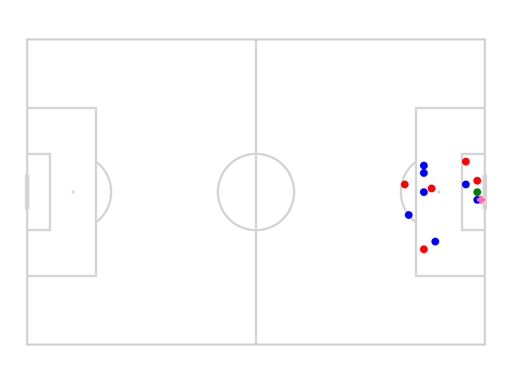

Im-xG: 0.03
SB-xG: 0.85
Diff:  0.82


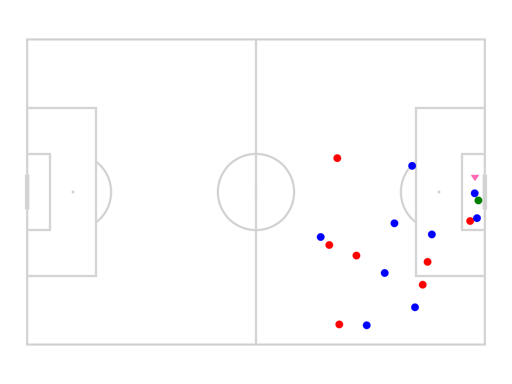

Im-xG: 0.03
SB-xG: 0.84
Diff:  0.81


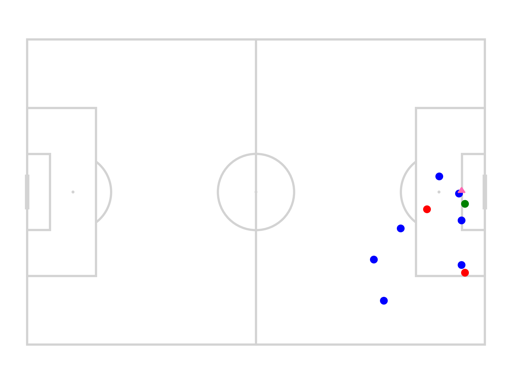

Im-xG: 0.06
SB-xG: 0.85
Diff:  0.79


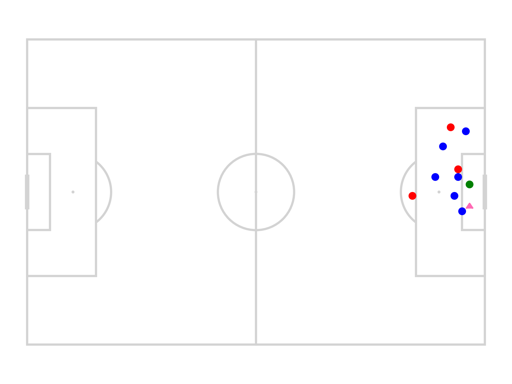

Im-xG: 0.03
SB-xG: 0.81
Diff:  0.78


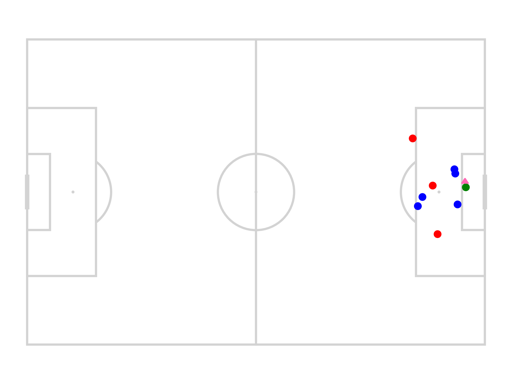

Im-xG: 0.09
SB-xG: 0.85
Diff:  0.76


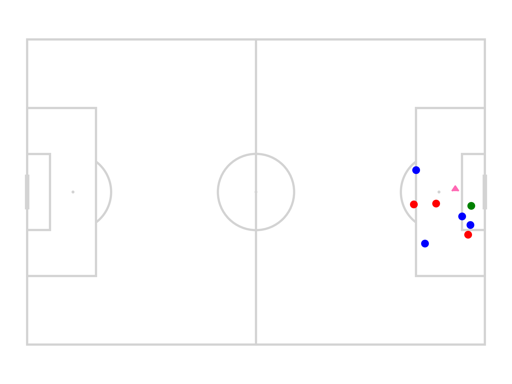

Im-xG: 0.04
SB-xG: 0.77
Diff:  0.73


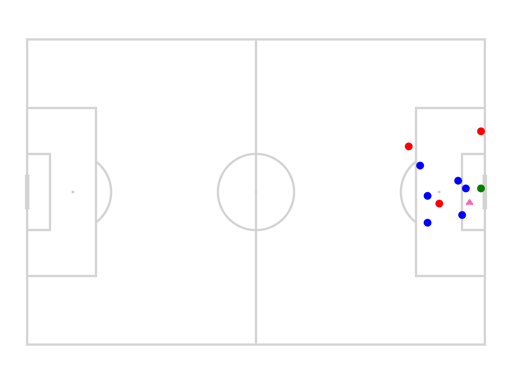

Im-xG: 0.08
SB-xG: 0.81
Diff:  0.73


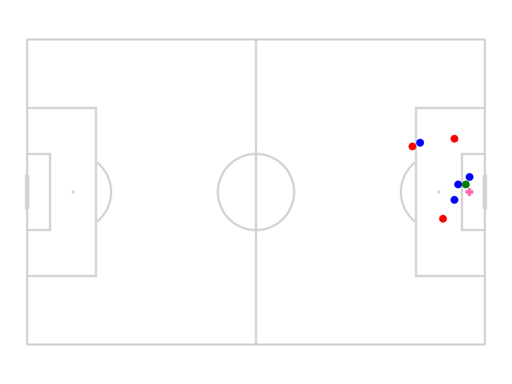

Im-xG: 0.05
SB-xG: 0.75
Diff:  0.69


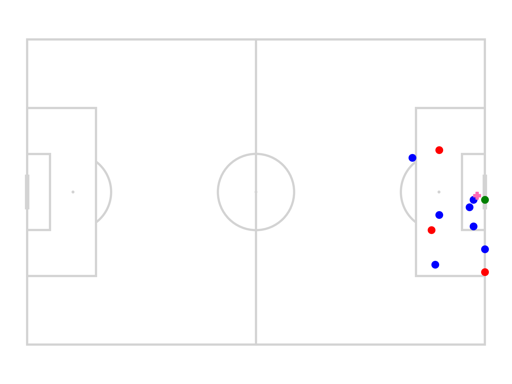

Im-xG: 0.03
SB-xG: 0.71
Diff:  0.67


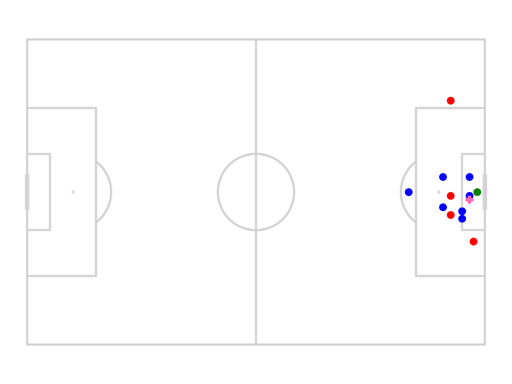

In [17]:
for _, p in predictions.sort_values(by='diff', ascending=False).head(10).iterrows():
    img = PILImage.create(p['path']).to_thumb(512, 512)
    print(f'Im-xG: {p["xg"]:.2f}')
    print(f'SB-xG: {p["sb_xg"]:.2f}')
    print(f'Diff:  {p["diff"]:.2f}')
    display(img)

In [ ]:
# Show the most different N predictions (top & bottom)